<a href="https://colab.research.google.com/github/jodog0412/US-STOCKS-INVESTMENT-ASSISTANCE/blob/master/US_STOCK_INVESTMENT_ASSISTANCE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# US Stock Analysis
- 포트폴리오 시각화
- 포트폴리오 수익률 분석
- 종목 검색
- 재무제표 비교
- 재무제표 시각화

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
%cd /content/drive/MyDrive/Colab/US_STOCK_INVESTMENT_ASSISTANCE
!ls

## IMPORT FUNCTION

In [ ]:
!pip install yfinance
!pip install finance-datareader
import numpy as np
import pandas as pd
import yfinance as yf
import FinanceDataReader as fdr
import matplotlib.pyplot as plt
import seaborn as sns

from google.colab import auth
auth.authenticate_user()
import gspread
from google.auth import default
creds, _ = default()
gc = gspread.authorize(creds)

## DATAFRAME

In [ ]:
# DATA
sheet=gc.open('US_STOCK').sheet1
data_raw=pd.DataFrame(sheet.get_all_values())
pf=pd.DataFrame(data=data_raw.values,
                columns=["TICKER","TAG","AVER_PRICE","STOCK_NUM","STOCK_QUANTITY"])
pf=pf.sort_values(by="TICKER")
ticker=pf.loc[:,"TICKER"].values
date='2022-09-11'

## DATA VISUALIZATION

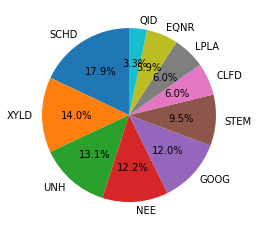

In [61]:
def portfolio_plt(pf):
    pf=pf.sort_values("STOCK_QUANTITY",ascending=False)
    pf_plot=plt.pie(pf["STOCK_QUANTITY"],labels=pf.loc[:,"TICKER"],
                    autopct='%.1f%%',startangle=90)    
    return(plt.show(pf_plot))
portfolio_plt(pf) 

In [ ]:
def holds_dataframing(company,date): #수익률 데이터화
    data_yf=yf.download(list(ticker),start='2022-01-01',end=date,progress=False)
    recent_price=data_yf['Adj Close'].iloc[-1]
    profit=(recent_price/pf['AVER_PRICE'].values.astype(float)-1)*100
    prf=profit.sort_values(ascending=False)
    return(prf)

holds_dataframing(ticker,date) #회사 리스트,날짜

## TICKER SEARCH

In [ ]:
# ['가정용품', '개인, 가정 용품 및 서비스', '건설 및 엔지니어링', 
# '건설장비 및 대형차, 기차, 배', '건축 자재', '교육서비스', '기타 금융업',
# '다양한 금융서비스', '다양한 산업재 도매업', '다양한 소매업',
# '레저 상품', '메탈&마이닝', '미디어 및 출판', '반도체 및 반도체 장비', 
# '보험', '복합 기업', '복합 유틸리티', '부동산 운영 관리',
# '비즈니스교육', '사무기기', '생명과학 및 메디컬 리서치', '석유',
# '섬유 및 의류', '소프트웨어 및 IT서비스', '수도 유틸리티',
# '식품 및 담배', '식품 및 약품소매', '오일 및 가스', 
# '오일 및 가스 장비 및 서비스', '용기 및 포장', '우라늄', '우주항공 및 국방',
# '운송 인프라', '운송업', '은행', '음료', '자동차 및 자동차 부품', 
# '재생에너지', '전기 유틸리티', '전문 및 상업 서비스', '전문품 상점',
# '전자 장비 및 부품', '제약', '종이 및 임산물', '주택 및 상업용 리츠', 
# '주택건설', '천연가스 유틸리티', '커뮤니케이션 및 네트워킹',
# '컴퓨터, 전화 및 가전제품', '통신 서비스', '통합 하드웨어 및 소프트웨어', 
# '투자은행 및 서비스', '핀테크', '학교',
# '헬스케어 업체 및 서비스', '헬스케어 장비 및 용품', '호텔 및 엔터테인먼트', '화물 및 물류 서비스', '화학']

date_start='2022-08-01'
def ticker_search(index,sector):
    global tsf
    data_fdr = fdr.StockListing(index)
    data_fdr = dict(list(data_fdr.groupby('Industry')))
    tickers=list(data_fdr[sector]['Symbol'].values)
    data_by_sector=yf.download(tickers,start=date_start,end=date,progress=False)
    data_by_sector=data_by_sector['Adj Close'].iloc[-1]-data_by_sector['Adj Close'].iloc[0]
    tsf=pd.Series(data_by_sector).sort_values(ascending=False)
    # tf.to_excel(excel_writer="./data/%s_PROFIT_%s.xlsx"%(index,sector))
    return(tsf)
ticker_search('NYSE','호텔 및 엔터테인먼트')

In [ ]:
search_top=tsf[:10]
search_top

## FINANCIALS COMPARISON

In [ ]:
holds=['NEE','STEM','GOOG','EQNR','UNH','CLFD','LPLA']
view=['OXY','EQNR']

finan=[]
def financial_shape(ticker):
    ticker_yf=yf.Ticker(ticker)
    info=ticker_yf.info
    if "trailingPE" in info:
        finan.append([info["trailingPE"], info["forwardPE"], info["priceToBook"],
                      info["pegRatio"], info["returnOnEquity"],info["shortPercentOfFloat"],
                      info["quickRatio"]])
    else:
        finan.append(["NaN", info["forwardPE"], info["priceToBook"],
                      info["pegRatio"], info["returnOnEquity"], info["shortPercentOfFloat"],
                      info["quickRatio"]])

def financial_comparison(tickerlist):
    for i in tickerlist: 
        financial_shape(i)
    df=pd.DataFrame(data=finan,
                    index=tickerlist,
                    columns=['PER', 'FPER', 'PBR',
                             'PEGR', 'ROE', 'short%', 'qRatio'])
    df=df.sort_values('FPER',ascending=False)
    return df

financial_comparison(view)

## FINANCIALS VISUALIZATION

In [ ]:
def plt_earning(tickerlist):
    fig, axs = plt.subplots(len(tickerlist))
    for i in range(0,len(tickerlist)):
        #get datas for balance sheet
        ticker_yf=yf.Ticker(tickerlist[i])
        earning=ticker_yf.earnings
        #plotting
        sns.lineplot(data=earning,ax=axs[i],legend=False)
        if i==0:
            axs[i].legend(["Revenue","Earnings"],
                          loc=2,
                          prop={'size': 6})
        axs[i].set_title(tickerlist[i])
    plt.show()

def plt_balance(tickerlist):
    fig, axs = plt.subplots(len(tickerlist))
    for i in range(0,len(tickerlist)):
        #get datas for balance sheet
        ticker_yf=yf.Ticker(tickerlist[i])
        balance=ticker_yf.balance_sheet.loc[["Total Assets","Total Liab","Total Stockholder Equity","Cash"]]
        balance=balance.transpose().sort_index()
        #plotting
        sns.lineplot(data=balance,ax=axs[i],legend=False)
        if i==0:
            axs[i].legend(["Total Assets","Total Liab","Total Stockholder Equity","Cash"],
                          loc=2,
                          prop={'size': 6})
        axs[i].set_title(tickerlist[i])
    plt.show()

def plt_cashflow(tickerlist):
    fig, axs = plt.subplots(len(tickerlist))
    for i in range(0,len(tickerlist)):
        #get datas for balance sheet
        ticker_yf=yf.Ticker(tickerlist[i])
        cashflow=ticker_yf.cashflow.loc[["Total Cash From Operating Activities",
                                         "Total Cashflows From Investing Activities",
                                         "Total Cash From Financing Activities"]]
        cashflow=cashflow.transpose().sort_index()
        sns.lineplot(data=cashflow,ax=axs[i],legend=False)
        if i==0:
            axs[i].legend(["Total Cash From Operating Activities",
                           "Total Cash From Investing Activities",
                           "Total Cash From Financing Activities"],
                          loc=2,
                          prop={'size': 6})
        axs[i].set_title(tickerlist[i])
    plt.show()

plt_earning(view)
plt_balance(view)
plt_cashflow(view)